It should be clear from the back posts on this blog ([1](https://austinrochford.com/posts/2015-10-05-bayes-survival.html) [2](https://austinrochford.com/posts/2017-10-02-bayes-param-survival.html) [3](https://austinrochford.com/posts/revisit-survival-pymc.html)) that I have a long-standing interesting in [survival analysis](https://en.wikipedia.org/wiki/Survival_analysis).  Over the last few years, I have been sporadically learning about joint models for longitudinal and time-to-event data.  These models augment survival models by incorporating information from other (non-survival) outcomes repeatedly measured from the subjects over time.  The resulting models can provide better survival estimates by incorporating this information.  Recently I succeeded in wrapping my head around the theory of one class of such models, and wanted to record that understanding for my future self here, along with any one else this may help.  This post contains a crash course in the basics of these joint models, along with a worked example in Python using [PyMC](https://www.pymc.io/welcome.html).

My present understanding of this topic is largely based on [Dimitris Rizopoulos's](https://www.drizopoulos.com/) excellent presentation [_Joint Modeling of Longitudinal and Time-to-Event Data
with Applications in R_](https://www.drizopoulos.com/courses/EMC/ESP72.pdf) and the [documentation](https://drizopoulos.github.io/JMbayes2/) for his R package, `JMBayes2`.

## Theory

### Surival analysis

For the survival component of our models, we will use the [proportional hazards model](https://en.wikipedia.org/wiki/Proportional_hazards_model#The_Cox_model) that I have written about in two previous posts ([2023](https://austinrochford.com/posts/revisit-survival-pymc.html), [2015](https://austinrochford.com/posts/2015-10-05-bayes-survival.html)).  In this model, we represent the [hazard function](https://en.wikipedia.org/wiki/Survival_analysis#Hazard_function_and_cumulative_hazard_function) of the $i$-th subject associated with covariates $\mathbf{x}_i$ as

$$\lambda(t\ |\ \mathbf{x}_i) = \lambda_0(t) \cdot \exp(\alpha \cdot \mathbf{x}_i),$$

where $\lambda_0(t)$ is the baseline hazard at time $t$ and $\alpha$ is a vector of regression coefficients.

In this post, we will use the equivalent Poisson model discussed in the past posts to perform inference on these survival models.

### Joint model

The goal of this post is to show how we can improve our models by incorporating information from longitudinal outcomes into our survival models.  We denote the value of the longitudinal outcome for the $i$-th subject at time $t$ by $y_{i, t}$.  There are many ways to incorporate this information into our survival model (entire [books](https://www.routledge.com/Joint-Modeling-of-Longitudinal-and-Time-to-Event-Data/Elashoff-li-Li/p/book/9780367570576) have been written on the subject); in this post we take the approach of assuming independence of the survival and longitudinal outcomes conditional on random effects.  Specifically, we posit a random effects model for $y_{i, t}$, $y_{i, t} \sim N(\mu_{i, t}, \sigma^2)$ with

$$\mu_{i, t} = \beta \cdot \mathbf{x}_i + \gamma_{i, t},$$

where $\gamma_{i, t}$ is a set of [random effects](https://en.wikipedia.org/wiki/Random_effects_model) that can vary based on the subject and time.

Our conditional independence model assumes that the longitudinal outcome only influences survival through the randome effects $\gamma_{i, t}$, and incorporates these into the survival model as

$$\lambda(t\ |\ \mathbf{x}_i, \gamma_{i, t}) = \lambda_0(t) \cdot \exp(\alpha \cdot \mathbf{x}_i + \nu \cdot \gamma_{i, t}).$$

## Worked example

First we make the necessary Python imports and do some light configuration.

In [1]:
%matplotlib inline

In [2]:
import arviz as az
from matplotlib import pyplot as plt
import numpy as np
import nutpie
import polars as pl
import pymc as pm
from pytensor import tensor as pt
import seaborn as sns
from seaborn import objects as so

In [3]:
sns.set(color_codes=True)

### Load the data

In this worked example, we use longitudinal [data](https://vincentarelbundock.github.io/Rdatasets/doc/survival/pbcseq.html) from a Mayo Clinic study on primary biliary cirrhosis.

In [4]:
DATA_PATH = "https://vincentarelbundock.github.io/Rdatasets/csv/survival/pbcseq.csv"

In [5]:
COLS = [
    "id",
    "status",
    "trt",
    "day",
    "bili",
]

In [6]:
df = pl.read_csv(DATA_PATH, columns=COLS)

#### Data exploration and transformation

We examine this data below.

In [7]:
df

id,status,trt,day,bili
i64,i64,i64,i64,f64
1,2,1,0,14.5
1,2,1,192,21.3
2,0,1,0,1.1
2,0,1,182,0.8
2,0,1,365,1.0
…,…,…,…,…
312,0,0,0,6.4
312,0,0,206,5.5
312,0,0,390,7.4


* `id` is the case number of the subject.
* `status` indicates the subject's status at the end of their time in the study:
    * `0` indicates that they were alive at the end of the study,
    * `1` indicates that they exited the study upon receiving a liver transplant,
    * and `2` indicates that they died during the study.
* `trt` indicates if they received a placebo or the true treatment.
* `day` indicates the number of days between enrollment of the patient and the visit.
* `bili` indicates the concentration of [bilirubin](https://www.mayoclinic.org/tests-procedures/bilirubin/about/pac-20393041) in the blood during that visit, in mg/dL.

The survival outcome is derived from the `status`, and the longitudinal outcome is derived from `bili`.

First we (crudely) reduce the `day` column to monthly (really 30 day) granularity for ease of modeling.

In [8]:
df = df.with_columns(month=pl.col("day") // 30)

In [9]:
df

id,status,trt,day,bili,month
i64,i64,i64,i64,f64,i64
1,2,1,0,14.5,0
1,2,1,192,21.3,6
2,0,1,0,1.1,0
2,0,1,182,0.8,6
2,0,1,365,1.0,12
…,…,…,…,…,…
312,0,0,0,6.4,0
312,0,0,206,5.5,6
312,0,0,390,7.4,13


Next we reduce this longitudinal dataframe, which may have multiple rows per subject, to a dataframe that has one row per subject.

In [10]:
subj_df = (
    df.group_by("id")
    .agg(pl.col("month").max(), pl.col("trt").first(), pl.col("status").first())
    .sort("id")
)

In [11]:
subj_df

id,month,trt,status
i64,i64,i64,i64
1,6,1,2
2,107,1,0
3,24,1,2
4,60,1,2
5,48,0,1
…,…,…,…
308,38,1,0
309,42,0,0
310,45,1,0


* `id`, `trt`, and `status` have retained their meanings from the longitudinal data frame.
* `month` indicates the number of months (really 30-day periods) after which they exited the study.

### Modeling

We now turn to modeling impact of treatment on survival using this data.

#### Survival model

We first implement a pure survival model for two reasons:

1. it is a key component of the joint model, and
2. its inferences will provide a good baseline against which to compare those of the joint model.

First we derive NumPy arrays indicating the time each subject spent in the study (`t`), whether or not they died during the study (`died`), and whether or not they were treated (`trt`).

In [12]:
t = subj_df["month"].to_numpy()
died = subj_df["status"].eq(2).to_numpy()
trt = subj_df["trt"].eq(1).to_numpy()

Next we derive some ancillary quantities necessary to use a Poisson likelihood to perform inference on the proportional hazard model.  For a detailed treatment of these quantities, refer to a prior [post](https://austinrochford.com/posts/revisit-survival-pymc.html).

In [13]:
exposed = np.full((subj_df.shape[0], t.max() + 2), True, dtype=np.bool_)
np.put_along_axis(exposed, t[:, np.newaxis] + 1, False, axis=1)
exposed = np.minimum.accumulate(exposed, axis=1)

In [14]:
died_ = np.full_like(exposed, False, dtype=np.bool_)
np.put_along_axis(died_, t[:, np.newaxis], died[:, np.newaxis], axis=1)

assert (died_ & ~exposed).sum() == 0

We are now ready to begin building the survival model with PyMC.  For the baseline hazard we choose a hierachical normal prior,

$$
\begin{align}
    \mu_{\lambda_0}
        & \sim N(0, 2.5^2) \\
    \sigma_{\lambda_0}
        & \sim \text{Half}-N(1) \\
    \log \lambda_0(t)
        & \sim N(\mu_{\lambda_0}, \sigma_{\lambda_0}^2).
\end{align}
$$

For computational efficiency, we implement this prior using a [non-centered parameterization](https://twiecki.io/blog/2017/02/08/bayesian-hierchical-non-centered/).

In [15]:
# the scale necessary to make a halfnormal distribution have unit variance
HALFNORMAL_SCALE = 1 / np.sqrt(1 - 2 / np.pi)

In [16]:
def noncentered_normal(name, *, dims, μ=None):
    if μ is None:
        μ = pm.Normal(f"μ_{name}", 0, 2.5)

    Δ = pm.Normal(f"Δ_{name}", 0, 1, dims=dims)
    σ = pm.HalfNormal(f"σ_{name}", 2.5 * HALFNORMAL_SCALE)

    return pm.Deterministic(name, μ + Δ * σ, dims=dims)

In [17]:
coords = {"drug": np.array([False, True]), "t": np.arange(t.max() + 2)}

In [18]:
with pm.Model(coords=coords) as surv_model:
    log_λ0 = noncentered_normal("log_λ0", dims="t")
    λ0 = pt.exp(log_λ0)

Now we introduce the regression component of the model, making survival dependent on treatment.

We let $\alpha_{\text{trt}} \sim N(0, 2.5^2)$ and define the hazard function as

$$\lambda(t\ |\ x_{\text{trt}, i}) = \lambda_0(t) \cdot \exp(\alpha_{\text{trt}} \cdot x_{\text{trt}, i}).$$

In [19]:
with surv_model:
    α_trt = pm.Normal("α_trt", 0, 2.5)

    λ = pt.outer(pt.exp(α_trt * trt), λ0)

Note that we have not included an intercept term in our regression, as that combined with the baseline hazard would lead to an [unidentified](https://en.wikipedia.org/wiki/Identifiability) model.

Finally we specify the Poisson likelihood for our model.

In [20]:
with surv_model:
    pm.Poisson("died", exposed * λ, observed=died_)

Before sampling, we define the cumulative survival function of our model, in order to obtain samples from its posterior predictive distribution.

In [21]:
with surv_model:
    λ_pred = pt.outer(pt.exp(α_trt * np.array([0, 1])), λ0)
    Λ_pred = λ_pred.cumsum(axis=1)
    sf_pred = pm.Deterministic("sf_pred", pt.exp(-Λ_pred), dims=("drug", "t"))

We are now ready to sample from our model.

In [22]:
SAMPLER_KWARGS = {"cores": 8, "seed": 1234567890}

In [23]:
surv_trace = nutpie.sample(nutpie.compile_pymc_model(surv_model), **SAMPLER_KWARGS)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,0,0.41,15
,1300,0,0.39,15
,1300,0,0.41,15
,1300,0,0.40,15
,1300,0,0.40,15
,1300,0,0.42,15


Standard sampling diagnostics show no cause for concern.

In [24]:
az.rhat(surv_trace).max().to_array().max()

<xarray.DataArray ()> Size: 8B
array(1.00598908)

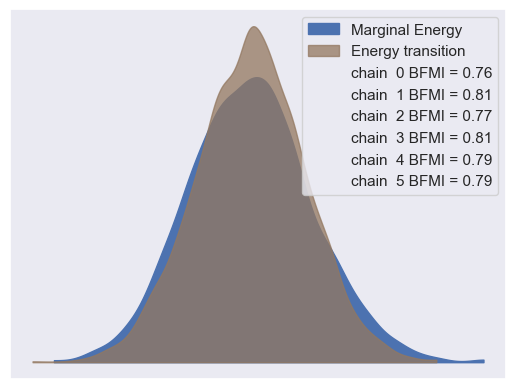

In [25]:
az.plot_energy(surv_trace);

This model shows little, if any, influence of treatment on survival, as illustrated in the following plots.

In [26]:
ALPHA = 0.05

ci = so.Perc([100 * ALPHA / 2, 100 * (1 - ALPHA / 2)])

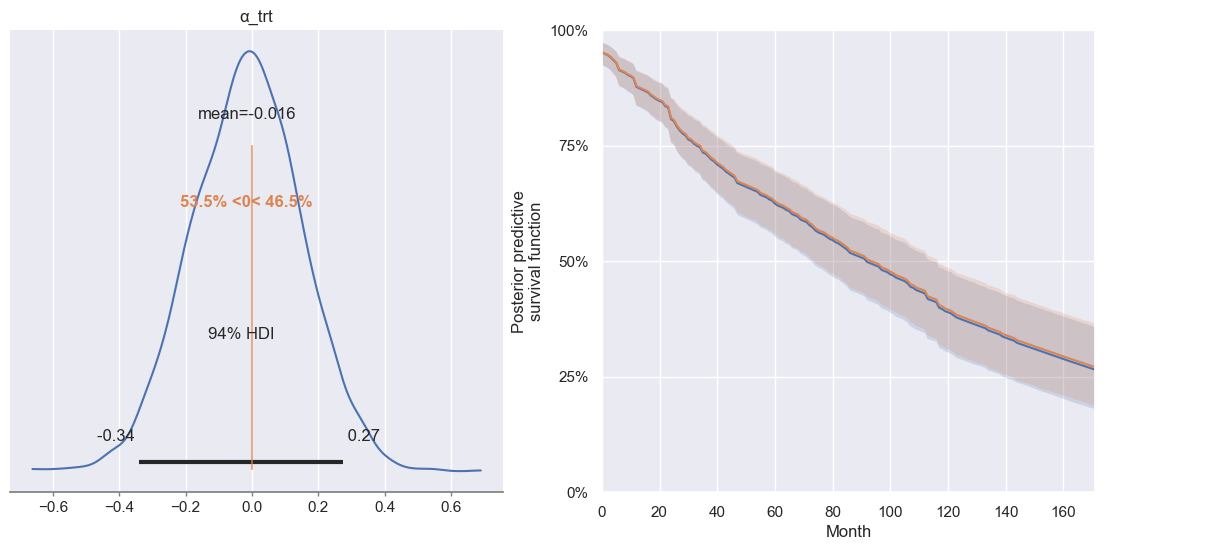

In [27]:
fig, (α_ax, sf_ax) = plt.subplots(figsize=(14, 6), ncols=2)

az.plot_posterior(surv_trace, var_names="α_trt", ref_val=0, ax=α_ax)

(
    so.Plot(
        surv_trace.posterior["sf_pred"].to_dataframe(), x="t", y="sf_pred", color="drug"
    )
    .add(so.Line(), so.Agg())
    .add(so.Band(), ci)
    .scale(color=so.Nominal(), y=so.Continuous().tick(every=0.25).label(like="{x:.0%}"))
    .limit(x=(0, t.max()), y=(0, 1))
    .label(x="Month", y="Posterior predictive\nsurvival function")
    .on(sf_ax)
    .show()
)

fig.tight_layout();

#### Joint model

We now get to the core of this post: implementing the joint model and observing how its inferences differ from those of the pure survival model.

First we derive a NumPy arrays for the longitudinal outcome, the concentration of bilirubin (`bili`), the index of each subject (`i`), and the time of each visit (`t_visit`).

In [28]:
def make_time_scaler(t_max):
    def time_scaler(t):
        return t // t_max

    return time_scaler

In [29]:
bili = df["bili"].to_numpy()
i = (df["id"] - df["id"].min()).to_numpy()

time_scaler = make_time_scaler(df["month"].max())
t_visit = time_scaler(df["month"].to_numpy())

We also add subject ID to our model's coordinates.

In [30]:
coords["id"] = subj_df["id"].to_numpy()

We are now ready to specify a random effects model for the longitudinal outcome.  We let

$$\mu_{\text{bili}, t, i} = \gamma_{0, i} + \gamma_{t, i} \cdot t + \beta_{\text{trt}} \cdot x_{\text{trt}, i}.$$

We place a normal prior on the treatment coefficient and noncentered hierarchical normal random effects priors on the intercept and time coefficient.

In [31]:
with pm.Model(coords=coords) as joint_model:
    γ0 = noncentered_normal("γ0", dims="id")
    γ_t = noncentered_normal("γ", dims="id")
    β_trt = pm.Normal("β_trt", 0, 2.5)

    μ_bili = γ0[i] + γ_t[i] * t_visit + β_trt * trt[i]

We then specify the likelihood for the longitudinal outcome as

$$\log y_{\text{bili}, i, t} \sim N(\mu_{\text{bili}, i, t}, \sigma_{\text{bili}}^2)$$

with $\sigma_{\text{bili}} \sim \text{Half}-N(2.5^2)$.

In [32]:
with joint_model:
    σ_bili = pm.HalfNormal("σ_bili", 2.5 * HALFNORMAL_SCALE)
    pm.Normal("log_bili", μ_bili, σ_bili, observed=np.log(bili))

The baseline hazard is specified the same as in the survival model.

In [33]:
with joint_model:
    log_λ0 = noncentered_normal("log_λ0", dims="t")
    λ0 = pt.exp(log_λ0)

Now let

$$\eta_{i, t} = \alpha_\text{trt} \cdot x_{\text{trt}, i} + \nu_0 \cdot \gamma_{0, i} + \nu_t \cdot \gamma_{t, i}$$

with $\alpha_\text{trt}, \nu_0, \nu_t \sim N(0, 2.5^2)$.

In [34]:
t_surv = time_scaler(coords["t"])

In [35]:
with joint_model:
    α_trt = pm.Normal("α_trt", 0, 2.5)
    ν0 = pm.Normal("ν0", 0, 2.5)
    ν_t = pm.Normal("ν_t", 0, 2.5)

    η = sum(
        [
            pt.atleast_2d(α_trt * trt + ν0 * γ0).T,
            ν_t * pt.outer(γ_t, pt.as_tensor(t_surv)),
        ]
    )

As before we model the hazard rate as $\lambda_{i, t} = \lambda_{0, t} \cdot \exp(\eta_{i, t})$ and use the Poisson likelihood.

In [36]:
with joint_model:
    λ = λ0 * pt.exp(η)

    pm.Poisson("died", exposed * λ, observed=died_)

As before, we define the cumulative survival function of our model, then sample from the model.  Note that we add the average values of the random effects $\gamma_0$ and $\gamma_t$ to obtain predictions for the average subject.

In [37]:
with joint_model:
    η_pred = pt.add.outer(
        α_trt * np.array([0, 1]) + ν0 * γ0.mean(),
        ν_t * γ_t.mean() * t_surv,
    )
    λ_pred = λ0 * pt.exp(η_pred)
    Λ_pred = λ_pred.cumsum(axis=1)
    sf_pred = pm.Deterministic("sf_pred", pt.exp(-Λ_pred), dims=("drug", "t"))

In [38]:
joint_trace = nutpie.sample(
    nutpie.compile_pymc_model(joint_model), target_accept=0.95, **SAMPLER_KWARGS
)

Progress,Draws,Divergences,Step Size,Gradients/Draw
,1300,1,0.14,31
,1300,2,0.13,31
,1300,1,0.15,31
,1300,1,0.15,31
,1300,1,0.14,31
,1300,0,0.13,31


Again, the standard sampling diagnostics show no cause for concern.

In [39]:
az.rhat(joint_trace).max().to_array().max()

<xarray.DataArray ()> Size: 8B
array(1.02313563)

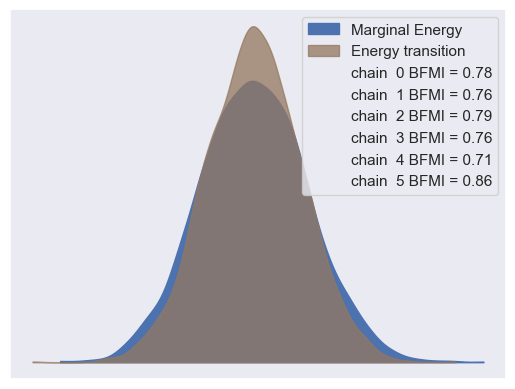

In [40]:
az.plot_energy(joint_trace);

This model shows a stronger influence of treatment on survival, as illustrated in the following charts.

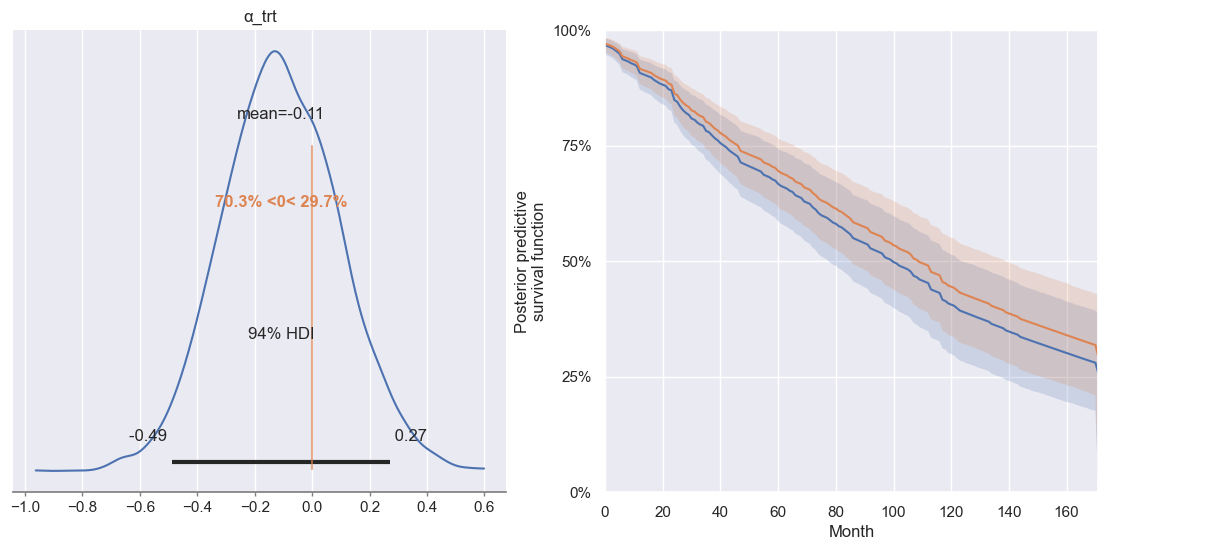

In [41]:
fig, (α_ax, sf_ax) = plt.subplots(figsize=(14, 6), ncols=2)

az.plot_posterior(joint_trace, var_names="α_trt", ref_val=0, ax=α_ax)

(
    so.Plot(
        joint_trace.posterior["sf_pred"].to_dataframe(),
        x="t",
        y="sf_pred",
        color="drug",
    )
    .add(so.Line(), so.Agg())
    .add(so.Band(), ci)
    .scale(color=so.Nominal(), y=so.Continuous().tick(every=0.25).label(like="{x:.0%}"))
    .limit(x=(0, t.max()), y=(0, 1))
    .label(x="Month", y="Posterior predictive\nsurvival function")
    .on(sf_ax)
    .show()
)

fig.tight_layout();

The actual data from this study contains more covariates and longitudinal outcomes than we have included in this model.  This example illustrates a framework for including more of the information in order to improve our estimate of the impact of treatment on survival.

This post is available as a Jupyter notebook [here](https://nbviewer.org/gist/AustinRochford/302a9e63d17d0ac3780b1c6b5dbbd9f0).

In [42]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Sat Mar 15 2025

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.29.0

pytensor  : 2.26.3
pymc      : 5.18.2
arviz     : 0.20.0
matplotlib: 3.9.2
numpy     : 1.26.4
polars    : 1.14.0
seaborn   : 0.13.2
nutpie    : 0.13.2

